# Dog Breed Classification

> This project is part of the Udacity Nanodegree Program "Data Scientist". 

## Table of Content

* [Project Overview](#ProjectOverview)
* [Inspect the dataset](#Dataset)
* [Train dog breed classifier](#Train)
* [Evaluate the model](#Evaluation)
* [Predict the class of an image](#Predict)

In [57]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import time

import torch
from torch.utils.data import DataLoader
from torchvision.io import read_image

from functions import CustomImageDataset, Evaluater, \
                        initialize_model, get_device, train_model, transform_image, augment_image

## Project Overview <a name=ProjectOverview></a>

The goal is to classify images of dogs according to their breed. We use the [Dog Breed Dataset available here](https://github.com/udacity/dog-project) to train our models. 

This notebook serves as a preparation towards developing an algorithm that is used as part of a mobile or web app. The developed code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.

For more details about the project, please read the README.md file. Thanks.

## Inspect the dataset <a name=Dataset></a>

Let us get a first intuition of the dataset. How many train/test/validation images do we have? How many classes? How is the distribution of the classes along the training dataset?  
These are all important questions that should be mentioned before training. if there are too less training images, we need more (or use data augmentation). If the classes are unequally distributed, one need to consider this during training, e.g.,  using class weights. 

First of all, load and inspect the datasets.

**Note that you need to download the datasets before, and you also need to adapt the path to where your dataset is located!**

In [7]:
# 
# Load dataset
train_dataset = CustomImageDataset(os.getcwd() + './../data/dogImages/train', augment = augment_image(augment_prop = 0.3))
test_dataset = CustomImageDataset(os.getcwd() + './../data/dogImages/test')
val_dataset = CustomImageDataset(os.getcwd() + './../data/dogImages/valid')
# 
# Get class names and ids
class_ids, class_names = train_dataset.get_classes()
# 
# Get label informations
train_label_indices, train_label_ids, train_label_names = train_dataset.get_labels()
test_label_indices, test_label_ids, test_label_names = test_dataset.get_labels()
val_label_indices, val_label_ids, val_label_names = val_dataset.get_labels()

Let us first check consistency of the datasets. It would be a problem, if some classes are not represented in the test or validation dataset. 

In [8]:
label_names_unique = np.unique(np.sort(train_label_names))
assert (label_names_unique == np.unique(np.sort(test_label_names))).all()
assert (label_names_unique == np.unique(np.sort(val_label_names))).all()
#
test_class_ids, test_class_names = test_dataset.get_classes()
val_class_ids, val_class_names = val_dataset.get_classes()
assert (test_class_ids == class_ids).all()
assert (val_class_ids == class_ids).all()
assert (test_class_names == class_names).all()
assert (val_class_names == class_names).all()

Display a sample to get an idea how the images look like. Let us use a dataloader for this.

... soooo cute dogs <3

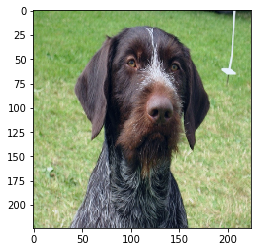

Image shape: torch.Size([3, 3, 224, 224])
Label index: 72
Label id: 73
Label name: German_wirehaired_pointer
Filepath: h:\work\repositories\Dog_Breed_Classification\source./../data/dogImages/train\073.German_wirehaired_pointer\German_wirehaired_pointer_05046.jpg


In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=3, shuffle=True)
# 
# Display image and label.
image, idx = next(iter(train_dataloader))
# 
label_index, label_id, label_name = train_dataloader.dataset.get_labels()
file_path = train_dataloader.dataset.get_file_path()
# 
# Prepare for display, plt.imshow requires HWC format...
# Just show the first image...
idx = idx[0]
img = image[0].squeeze()
img = img.permute(1,2,0)
# The images from the dataloader are likely not to be in range [0, 1]
img = (img - img.min())/(img.max() - img.min())
plt.imshow(img)
plt.show()
print(f"Image shape: {image.size()}")
print(f"Label index: {label_index[idx]}")
print(f"Label id: {label_id[idx]}")
print(f"Label name: {label_name[idx]}")
print(f"Filepath: {file_path[idx]}")

Print some initial and basic statistics.

In [11]:
# 
# Print statistics about the dataset
print('There are %d total dog categories.' % len(class_names))
print('There are %s total dog images.\n' % (len(train_label_ids) + len(test_label_ids) + len(val_label_ids)))
print('There are %d training dog images.' % len(train_label_ids))
print('There are %d validation dog images.' % len(val_label_ids))
print('There are %d test dog images.'% len(test_label_ids))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


Get class distribution for the training dataset.

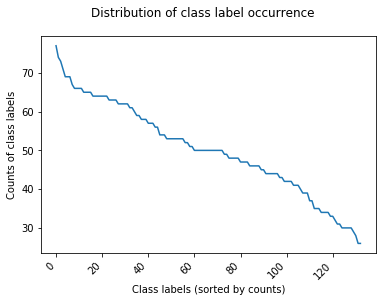

In [13]:
# 
# Use a pandas Dataframe to do the sorting
df_train = pd.DataFrame({'index': train_label_indices, 'ids': train_label_ids, 'names': train_label_names})
class_counts = df_train.groupby(['index', 'names']).count().sort_values(by = 'ids', ascending=False)
train_label_names_counts = class_counts.ids.values
train_label_indices_sorted = [item[0] for item in class_counts.ids.index]
train_label_names_sorted = [item[1] for item in class_counts.ids.index]
# 
# Plot the distribution
plt.plot(np.arange(len(train_label_names_sorted)), train_label_names_counts)
#   
plt.xlabel('Class labels (sorted by counts)')
plt.ylabel('Counts of class labels')
plt.xticks(rotation=45, ha='right')
plt.suptitle('Distribution of class label occurrence')
plt.show()

## Train dog breed classifier <a name=Train></a>

Since we got a first overview about the data, let us perform the first basic trainings. To do so, we need to define some parameters that are important for training as
* Which optimizer is used?
* Which loss function is used?
* Do we use a learning rate policy?
* Training parameters
* ... and many more. 

### Initialize model, parameters, optimizers, ...

First of all, we create a working directory that will contain all data that we collect during training. 

In [14]:
work_dir = os.getcwd() + './../training/test'
# 
# Ensure existence of folder
if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

Choose network and the device it should be trained on. For a first test, let us use randomly initialized weights, so train the model from scratch.

In [15]:
# 
# Choose model type
model_name = 'resnet18'
# 
# For initialization, we need the number of classes to adapt the end of the network.
class_ids, _ = train_dataset.get_classes()
model, input_size = initialize_model(model_name, len(class_ids), use_pretrained=False)

Choose the devide that is used for training.
Here, we use a CPU so that we don't need to care about memory. In addition, we will just train a view epochs here as proof of concept. 

However, use a GPU if you want to train more epochs.

In [16]:
device = get_device(cuda = False)
print('Chosen device type: {}'.format(device.type))

Chosen device type: cpu


Training parameters.  

As mentioned above, we will just run a view epochs here to see, if the functions work as expected. However, feel free to train more epochs.

In [21]:
# 
# Training params
num_epochs = 2
batch_size = 32
# 
# Loss parameters
use_loss_weights = True
# 
# Otimizer parameters
optimizer_str = 'sgd'
optimizer_str = 'adam'
lr = 1e-3
momentum = 0.9
weight_decay = 1e-5
# 
# LR scheduler 
lr_scheduler_step_size = int(num_epochs/2)
lr_scheduler_fac = 1e-1

Initialize model optimizer.

In [25]:
# 
# Optimizer
if (optimizer_str == 'sgd'):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, \
                                dampening=0, weight_decay=weight_decay, nesterov=False)
else: # Adam
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), \
                                 eps=1e-08, weight_decay=weight_decay, amsgrad=False)

Initialize learning rate scheduler

In [26]:
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, \
                                            step_size=lr_scheduler_step_size, gamma=lr_scheduler_fac)

Initialize loss for training. 

In [27]:
# 
# Loss
# 
# Calculate loss weights dependent on label occurances
loss_weights = None
if use_loss_weights:
    class_counts = df_train.groupby(['index', 'names']).count()
    train_label_names_counts = class_counts.ids.values
    train_label_indices_sorted = [item[0] for item in class_counts.ids.index]
    assert (train_label_indices_sorted == np.arange(0, len(train_label_indices_sorted))).all()
    #loss_weights = max(train_label_names_counts)/train_label_names_counts
    loss_weights = min(train_label_names_counts)/train_label_names_counts
    loss_weights = torch.Tensor(loss_weights)
# 
# Define the loss
loss_func = torch.nn.CrossEntropyLoss(weight=loss_weights, size_average=None, ignore_index=-100, \
                                      reduce=None, reduction='mean', label_smoothing=0.0)

### Test the training on a small subset of the training dataset

In the following, we just use the first 100 samples of the training dataset. For a real training, you should use all training samples, however, this is here for testing only.

In [28]:
# 
# Init the data loader
train_dataset = CustomImageDataset(os.getcwd() + './../data/dogImages/train', only_first_n_samples = 100)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

To see if the training runs as expected, one can have a look on the loss. However, it is even better to use a small subset of the validation dataset that is evaluated every $n$-th epoch. In the training function below, the model is only saved to the working directory if it has improved compared to the evaluations before.

In [30]:
# 
# Create evaluater class. Only use 30% of the dataset to speed-up evaluations.
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
evaluater = Evaluater(val_dataloader, k = 3, percentage = 0.3)

In [31]:
# 
# Remove existing log and model
if os.path.isfile(work_dir + '/train_log.pkl'):
    os.remove(work_dir + '/train_log.pkl')
if os.path.isfile(work_dir + '/best_model_state_dict.pt'):
    os.remove(work_dir + '/best_model_state_dict.pt')
# 
# Run a simple training...
model, log_train = train_model(work_dir, model, device, train_dataloader, \
                               loss_func = loss_func, optimizer = optimizer, lr_scheduler = lr_scheduler, \
                               num_epochs = num_epochs, \
                               evaluater = evaluater, eval_each_k_epoch = 1,
                               plot = True, stop = None)

Epoch 0/1
----------
Epoch 0.32, Loss: 5.0554
Epoch 0.64, Loss: 5.4094
Epoch 0.96, Loss: 5.5969
EVAL: Epoch 1, top_1: 0.9844, top_k: 0.9688
Epoch 1/1
----------
Epoch 1.32, Loss: 4.1403
Epoch 1.64, Loss: 4.1013
Epoch 1.96, Loss: 3.9299
EVAL: Epoch 2, top_1: 0.9961, top_k: 0.9609


The intermediate results are saved to the working directory, see
* train_log.pkl: containing loss values and evaluations gained during training
* best_model_state_dict.pt: model state dict containing weights of the best model (based on the evaluation during training)

In [47]:
#
# Read in training log and best model...
train_log = torch.load(work_dir + '/train_log.pkl')
model_state_dict_from_file = torch.load(work_dir + '/best_model_state_dict.pt')
model.load_state_dict(model_state_dict_from_file)

<All keys matched successfully>

Plot the loss based from the data contained in the log file.

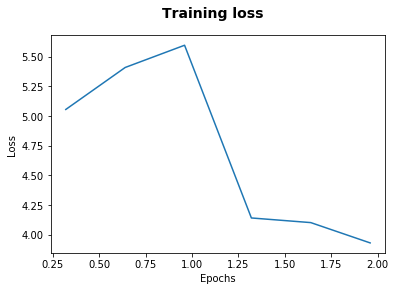

In [48]:
epochs = train_log['train_epoch']
loss = train_log['train_loss']
# 
fig = plt.figure()
fig.suptitle('Training loss', fontsize=14, fontweight='bold')
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.plot(epochs, loss)

Plot the evaluations based from the data contained in the log file.

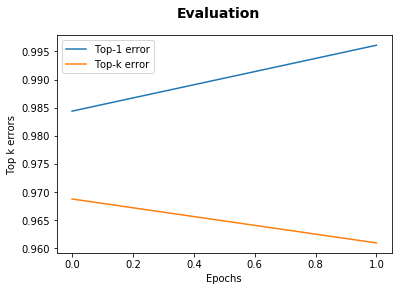

In [49]:
epochs = train_log['eval_epoch']
top1 = train_log['eval_top1']
topk = train_log['eval_topk']
# 
fig = plt.figure()
fig.suptitle('Evaluation', fontsize=14, fontweight='bold')
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Epochs')
ax.set_ylabel('Top k errors')
ax.plot(epochs, top1, label='Top-1 error')
ax.plot(epochs, topk, label='Top-k error')
ax.legend()

## Evaluate the model <a name=Evaluation></a>

To evaluate the model, we will again create an evaluation class object. But now, we will use the whole test dataset for evaluation, not just a small part of it as done during the training. 

In [51]:
# 
# Create evaluater class
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)
evaluater = Evaluater(test_dataloader, k = 3, percentage = 1.0)

In [54]:
# 
# Evaluate model and print results
accuracy, top_1_error, top_k_error = evaluater.eval(model, device)
# 
print('Evaluation results: ')
print('\t accuracy:\t{}'.format(accuracy))
print('\t top-1 error:\t{}'.format(top_1_error))
print('\t top-{}-error:\t{}'.format(3, top_k_error))

Evaluation results: 
	 accuracy:	0.009569377990430622
	 top-1 error:	0.9904306220095693
	 top-3-error:	0.9736842105263158


## Predict the class of an image <a name=Predict></a>

As a final proof of concept, let us predict the class of an image.

To make this running, we need to apply the same preprocessing steps as done in the dataloaders to fit the image as required for the model.

In [58]:
# 
# Read in image and apply transformation/preprocessing functions
img = read_image('./../data/dogImages/test/007.American_foxhound/American_foxhound_00522.jpg')
img = transform_image(width=input_size, height=input_size)(img.unsqueeze(0))
# 
# Get device used for prediction
device = get_device(cuda = False)
# 
# Shift to device and predict
model = model.to(device)
img = img.to(device)
start = time.time()
output = model(img)
_, preds = torch.max(output, 1)
end = time.time()
# 
# Print results
print('Prediction: ')
print('\t class index:\t\t{}'.format(preds[0]))
if (class_names is not None):
    print('\t class id:\t\t{}'.format(class_ids[preds[0]]))
    print('\t class name:\t\t{}'.format(class_names[preds[0]]))
print('\t execution time:\t{:.2f} ms'.format(1000*(end - start)))

Prediction: 
	 class index:		56
	 class id:		57
	 class name:		Dalmatian
	 execution time:	50.07 ms
